# Cassava Leaf Disease Classification - Exploratory Data Analysis

Quick Exploratory Data Analysis for [Cassava Leaf Disease Classification](https://www.kaggle.com/c/cassava-leaf-disease-classification) challenge    

This competition will challenge you to distinguish between several diseases that cause material harm to the food supply of many African countries. In some cases the main remedy is to burn the infected plants to prevent further spread, which can make a rapid automated turnaround quite useful to the farmers.

In [1]:
%%capture
!pip install ../input/timm-pip/timm-0.3.1-py3-none-any.whl

In [2]:
#import Libraries

import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

import tensorflow as tf

import tensorflow as tf
import torchvision
from fastai.vision.all import *
import timm

from pathlib import Path

from tqdm import tqdm

import plotly.graph_objects as go
import plotly_express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import cv2

from plotly.offline import init_notebook_mode
init_notebook_mode()

dataset_path = os.path.normpath("../input/cassava-leaf-disease-classification")
os.listdir(dataset_path)

BASE_DIR = "../input/cassava-leaf-disease-classification/"

In [3]:
#Checking Tensorflow Version
tf.__version__

'2.3.1'

# Explorative Data Analysis

In [4]:
#loading dataset inkl. first look
train_df = pd.read_csv(dataset_path + "/" + 'train.csv')
train_df.head()

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

In [10]:
#Total amount of images
len_df = len(train_df)
print(f"There are {len_df} images in the dataset")

There are 21397 images in the dataset


In [28]:
#All the differnet labels in the dataset
with open(os.path.join(BASE_DIR, "label_num_to_disease_map.json")) as file:
    map_classes = json.loads(file.read())
    map_classes = {int(k) : v for k, v in map_classes.items()}

print("All the differnet labels in the dataset:")
print(json.dumps(map_classes, indent=4))

All the differnet labels in the dataset:
{
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
}


In [12]:
#Image Shape in width, height and RGB-Channel
img_shapes = {}
for image_name in os.listdir(os.path.join(BASE_DIR, "train_images"))[:1]:
    image = cv2.imread(os.path.join(BASE_DIR, "train_images", image_name))
    img_shapes[image.shape] = img_shapes.get(image.shape, 0) + 1

print("The images have the shape (width, height, RGB-channel): ", img_shapes)

The images have the shape (width, height, RGB-channel):  {(600, 800, 3): 1}


In [26]:
#Adding Columns with Classname & Path to the training dataframe
train_df = pd.read_csv(os.path.join(BASE_DIR, "train.csv"))

train_df["class_name"] = train_df["label"].map(map_classes)

train_df['path'] = train_df['image_id'].map(lambda x:dataset_path +"/" "train_images" + "/" + "x")
train_df = train_df.drop(columns=['image_id'])
train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle dataframe

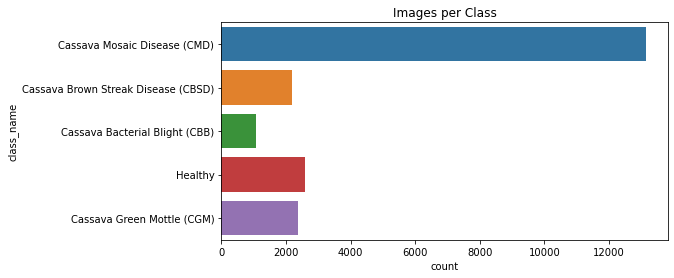

In [9]:
plt.figure(figsize=(8, 4))
plt.title("Images per Class")
sns.countplot(y="class_name", data=train_df);

In [18]:
base_path = Path('../input/cassava-leaf-disease-classification')
train_img_dir = base_path /'train_images'
test_img_dir = base_path /'test_images'

train_df = pd.read_csv(base_path/'train.csv')
diseaseMapping = pd.read_json(base_path/'label_num_to_disease_map.json', typ='series')

train_images = os.listdir(base_path/'train_images/')
test_images = os.listdir(base_path/'test_images/')

mappingDict = diseaseMapping.to_dict()

train_df = train_df.replace(mappingDict)

healthyImages = train_df[train_df['label'] == 'Healthy']['image_id'].to_list()
cbbImages = train_df[train_df['label'] == 'Cassava Bacterial Blight (CBB)']['image_id'].to_list()
cbsdImages = train_df[train_df['label'] == 'Cassava Brown Streak Disease (CBSD)']['image_id'].to_list()
cgmImages = train_df[train_df['label'] == 'Cassava Green Mottle (CGM)']['image_id'].to_list()
cmdImages = train_df[train_df['label'] == 'Cassava Mosaic Disease (CMD)']['image_id'].to_list()

labelCounts = train_df['label'].value_counts().reset_index()
labelCounts.columns = ['Label', 'Number of Observations']

train = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
train['disease'] = train.label.map({0:"Cassava Bacterial Blight (CBB)",
1:"Cassava Brown Streak Disease (CBSD)",
2:"Cassava Green Mottle (CGM)",
3:"Cassava Mosaic Disease (CMD)",
4:"Healthy"})
diseases = train.disease.value_counts()

fig = px.pie(diseases,
             values='disease',
             names=diseases.index,
             #color_discrete_sequence=orange_black,
             hole=.3)
fig.update_traces(textinfo='percent+label', pull=0.05)
fig.show()

Class CMD has by far the most images in the dataset, so it is unbalanced.

In [19]:
#defining plot functions for RGB Plots

def showImages(images):

    # Extract 9 random images from it
    random_images = [np.random.choice(images) for i in range(9)]

    # Adjust the size of your images
    plt.figure(figsize=(10,8))

    # Iterate and plot random images
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        img = plt.imread(train_img_dir/random_images[i])
        plt.imshow(img, cmap='gray')
        plt.axis('off')

    # Adjust subplot parameters to give specified padding
    plt.tight_layout()
    
def showHistogram(sample_img, title):
    f = plt.figure(figsize=(16,8))
    f.add_subplot(1,2, 1)

    raw_image = plt.imread(train_img_dir/sample_img)
    plt.imshow(raw_image, cmap='gray')
    plt.colorbar()
    plt.title(title)
    print(f"Image dimensions:  {raw_image.shape[0],raw_image.shape[1]}")
    print(f"Maximum pixel value : {raw_image.max():.1f} ; Minimum pixel value:{raw_image.min():.1f}")
    print(f"Mean value of the pixels : {raw_image.mean():.1f} ; Standard deviation : {raw_image.std():.1f}")

    f.add_subplot(1,2, 2)

    #_ = plt.hist(raw_image.ravel(),bins = 256, color = 'orange',)
    _ = plt.hist(raw_image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
    _ = plt.hist(raw_image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
    _ = plt.hist(raw_image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
    _ = plt.xlabel('Intensity Value')
    _ = plt.ylabel('Count')
    _ = plt.legend(['Red_Channel', 'Green_Channel', 'Blue_Channel'])
    plt.show()
    
    
    
def load_image(image_id):
    image = cv2.imread(str(train_img_dir/image_id))
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def showChannelDistribution(images, leafType):
    imageArray = [load_image(image_id) for image_id in images]
    
    red_values = [np.mean(imageArray[idx][:, :, 0]) for idx in range(len(imageArray))]
    green_values = [np.mean(imageArray[idx][:, :, 1]) for idx in range(len(imageArray))]
    blue_values = [np.mean(imageArray[idx][:, :, 2]) for idx in range(len(imageArray))]
    values = [np.mean(imageArray[idx]) for idx in range(len(imageArray))]
    
    hist_data = [red_values, green_values, blue_values, values]
    group_labels = ['Red', 'Green', 'Blue', 'All']

    fig = ff.create_distplot(hist_data, group_labels,colors = ['red', 'green','blue','grey'])
    fig.update_layout(template = 'plotly_white', title_text = f'Channel Distribution - {leafType}')
    fig.show()
    return hist_data

def showBoxPlot(histData, leafType):
    figData = []
    for i, name in zip(range(3), ['Red', 'Green', 'Blue']):
        trace = go.Box(y = histData[i], name = name, boxpoints='all', marker_color  = name)
        figData.append(trace)

    fig = go.Figure(figData)
    fig.update_layout(title_text = f'Pixel Intensity Distribution - {leafType}', template = 'plotly_white')
    fig.show() 
    
    


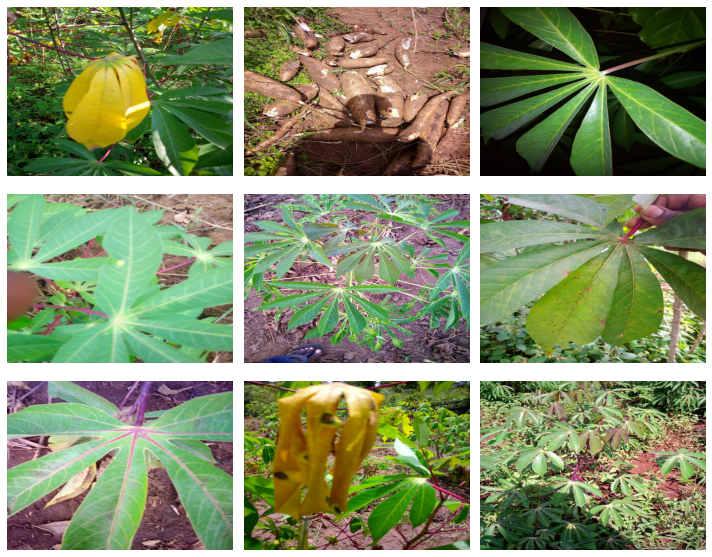

In [20]:
showImages(healthyImages)
#showImages(cmdImages)
#showImages(cgmImages)
#showImages(cbsdImages)
#showImages(cbbImages)

A batch of nine healthy images

Image dimensions:  (600, 800)
Maximum pixel value : 255.0 ; Minimum pixel value:0.0
Mean value of the pixels : 82.9 ; Standard deviation : 59.0


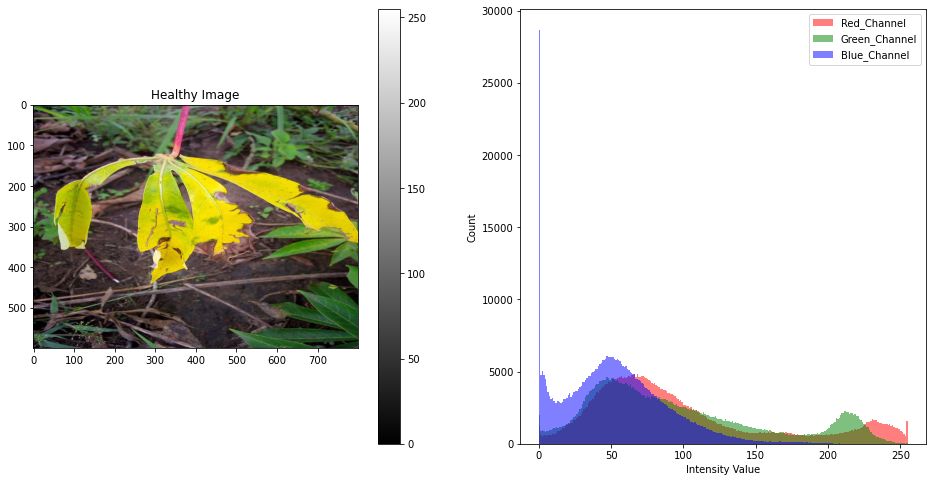

In [21]:
showHistogram(healthyImages[0], 'Healthy Image')
#showHistogram(cmdImages[0], 'CMD Image')
#showHistogram(cgmImages[0], 'CGM Image')
#showHistogram(cbsdImages[0], 'CBSD Image')
#showHistogram(cbbImages[0], 'CBB Image')

In [23]:
data = showChannelDistribution(healthyImages, 'Healthy')
#data = showChannelDistribution(cbbImages, 'CBB Images')
#data = showChannelDistribution(cbsdImages, 'CBSD Images')
#data = showChannelDistribution(cgmImages, 'CGM Images')
#data = showChannelDistribution(cmdImages, 'CMD Images')

These are the RGB-Channel Values of all Healthy Images.

In [24]:
showBoxPlot(data, 'Healthy Leaves')
#showBoxPlot(data, 'CBB Images')
#showBoxPlot(data, 'CBSD Images')
#showBoxPlot(data, 'CGM Images')
#showBoxPlot(data, 'CMD Images')

Insights:
* CGM types images have the highest median RGB values
* CBB type images have the lowest median RGB values
* The channel intensity median values follow this trend G>R>B

In [25]:
channelIntensityDf = pd.DataFrame(
    {
        'Leaf Type' : ['Healthy', 'CBB','CBSD', 'CGM', 'CMD'], 
        'Red Channel Mean' : [108,102,106,113,110],
        'Green Channel Mean' : [126,117,123,128,128],
        'Blue Channel Mean' : [80,66,72,85,80]
    }
)

channelIntensityDf.style.background_gradient(cmap='Greens', axis = 0)

# Model Development

In [29]:
set_seed(999)

dataset_path = Path('../input/cassava-leaf-disease-classification')
os.listdir(dataset_path)

BASE_DIR = "../input/cassava-leaf-disease-classification/"

train_df = pd.read_csv("../input/cassava-leaf-disease-classification/train.csv")

In [31]:
train_df = pd.read_csv(os.path.join(BASE_DIR, "train.csv"))

train_df["class_name"] = train_df["label"].map(map_classes)

train_df['path'] = train_df['image_id'].map(lambda x:dataset_path/'train_images'/x)
train_df = train_df.drop(columns=['image_id'])
train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle dataframe

train_df = train_df[["label", "path"]]

In [32]:
from PIL import Image

im = Image.open(train_df['path'][1])
width, height = im.size
print(width,height) 

800 600


**Image Augmentation to increase the training dataset**

In [33]:
item_tfms = RandomResizedCrop(224, min_scale=0.75, ratio=(1.,1.))
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
bs=64

**Defining an image data loader for the model**

In [35]:
dls = ImageDataLoaders.from_df(train_df, #pass in train DataFrame
                               valid_pct=0.1, #80-20 train-validation random split
                               seed=999, #seed
                               label_col=0, #label is in the first column of the DataFrame
                               fn_col=1, #filename/path is in the second column of the DataFrame
                               bs=bs, #pass in batch size
                               item_tfms=item_tfms, #pass in item_tfms
                               batch_tfms=batch_tfms) #pass in batch_tfms

Random Example Batch: 


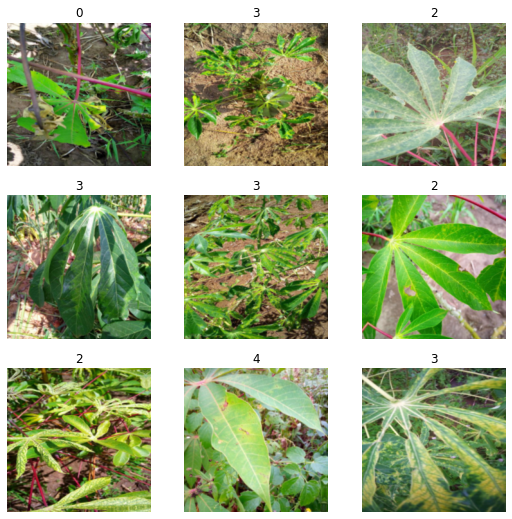

In [37]:
print("Random Example Batch: ")
dls.show_batch()

In [38]:
# Making pretrained weights work without needing to find the default filename
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
        os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/timmefficientnet/tf_efficientnet_b3_ns-9d44bf68.pth' '/root/.cache/torch/hub/checkpoints/tf_efficientnet_b3_ns-9d44bf68.pth'

In [39]:
# Config of the timm learner
from timm import create_model
from fastai.vision.learner import _update_first_layer

def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")
        
def create_timm_model(arch:str, n_out, cut=None, pretrained=True, n_in=3, init=nn.init.kaiming_normal_, custom_head=None,
                     concat_pool=True, **kwargs):
    "Create custom architecture using `arch`, `n_in` and `n_out` from the `timm` library"
    body = create_timm_body(arch, pretrained, None, n_in)
    if custom_head is None:
        nf = num_features_model(nn.Sequential(*body.children())) * (2 if concat_pool else 1)
        head = create_head(nf, n_out, concat_pool=concat_pool, **kwargs)
    else: head = custom_head
    model = nn.Sequential(body, head)
    if init is not None: apply_init(model[1], init)
    return model

def timm_learner(dls, arch:str, loss_func=None, pretrained=True, cut=None, splitter=None,
                y_range=None, config=None, n_out=None, normalize=True, **kwargs):
    "Build a convnet style learner from `dls` and `arch` using the `timm` library"
    if config is None: config = {}
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    model = create_timm_model(arch, n_out, default_split, pretrained, y_range=y_range, **config)
    learn = Learner(dls, model, loss_func=loss_func, splitter=default_split, **kwargs)
    if pretrained: learn.freeze()
    return learn

**Building the model**

In [40]:
learn = timm_learner(dls, 
                    'tf_efficientnet_b3_ns', 
                     opt_func = ranger,
                     loss_func=LabelSmoothingCrossEntropy(),
                     metrics = [accuracy]).to_native_fp16()

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=0.0691830962896347)

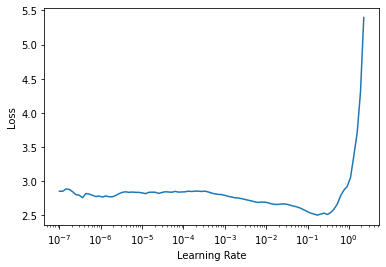

In [41]:
learn.lr_find()

**Finding the right learningrate with the lowest loss**

In [42]:
learn.freeze()
learn.fit_flat_cos(1,1e-1, wd=0.5, cbs=[MixUp()])

In [43]:
learn.save('stage-1')

Path('models/stage-1.pth')

In [44]:
learn = learn.load('stage-1')

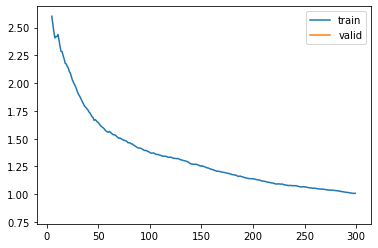

In [45]:
learn.recorder.plot_loss()

SuggestedLRs(lr_min=0.0006309573538601399, lr_steep=3.311311274956097e-06)

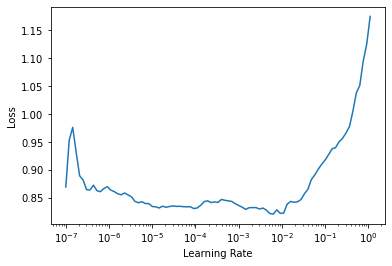

In [46]:
learn.unfreeze()
learn.lr_find()

**Unfreeze the model and again finding the learning rate with the lowest loss**

**and Train for 10 epochs, since this seams to be the optimal amount**

In [47]:
learn.unfreeze()
learn.fit_flat_cos(12,2e-2,pct_start=0,cbs=[MixUp()])

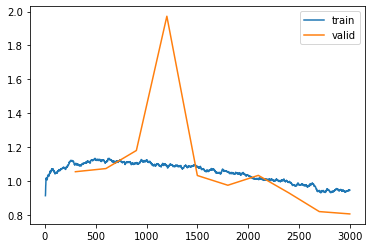

In [48]:
learn.recorder.plot_loss()

In [49]:
learn = learn.to_native_fp32()

In [50]:
learn.save('stage-2')

Path('models/stage-2.pth')

In [51]:
learn.export()

In [52]:
interp = ClassificationInterpretation.from_learner(learn)

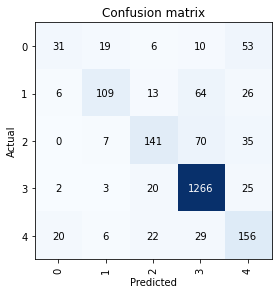

In [53]:
interp.plot_confusion_matrix()

In [54]:
sample_df = pd.read_csv(dataset_path/'sample_submission.csv')
sample_df.head()

image_id  label
0  2216849948.jpg      4

In [55]:
_sample_df = sample_df.copy()
_sample_df['path'] = _sample_df['image_id'].map(lambda x:dataset_path/'test_images'/x)
_sample_df = _sample_df.drop(columns=['image_id'])
test_dl = dls.test_dl(_sample_df)

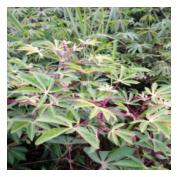

In [56]:
test_dl.show_batch()

In [57]:
preds, _ = learn.tta(dl=test_dl, n=8, beta=0)

In [58]:
sample_df['label'] = preds.argmax(dim=-1).numpy()

In [59]:
sample_df.to_csv('submission.csv',index=False)